Today we're teaching a neural network to distinguish images from the CIFAR-10 dataset, which contains tiny pictures of airplanes, birds, cats, dogs, and more.

We'll start simple, training a baseline model, and then use it as a jumping off point to play with some new concepts like discriminative learning rates and mixed precision training.

Let's roll up our sleeves and dive in!


# Understanding CIFAR-10
CIFAR-10 is a classic dataset used in deep learning. It contains ten categories, tiny images (32x32 pixels), and 60,000 samples. Our goal is to train a network that can distinguish these 10 categories.

In [2]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

In [3]:
path = untar_data(URLs.CIFAR)

### Get the labels from the dataset

Before we train the model, we need to make sure it knows what it's looking at.
The images in CIFAR-10 are stored in folders named after their categories—so we'll use those folder names as our labels.

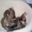

In [15]:
img = PILImage.create((path/'train/cat').ls()[0])
img.to_thumb(192)

We'll create something called DataLoaders to help our neural network
efficiently grab batches of images for training.

In [26]:
cifar = DataBlock(
    blocks = [ImageBlock, CategoryBlock],
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    batch_tfms=aug_transforms(size=16, min_scale=0.75)  
)

In [28]:
dls = cifar.dataloaders(path/'train', 
                        bs = 256, 
                        seed = 42)

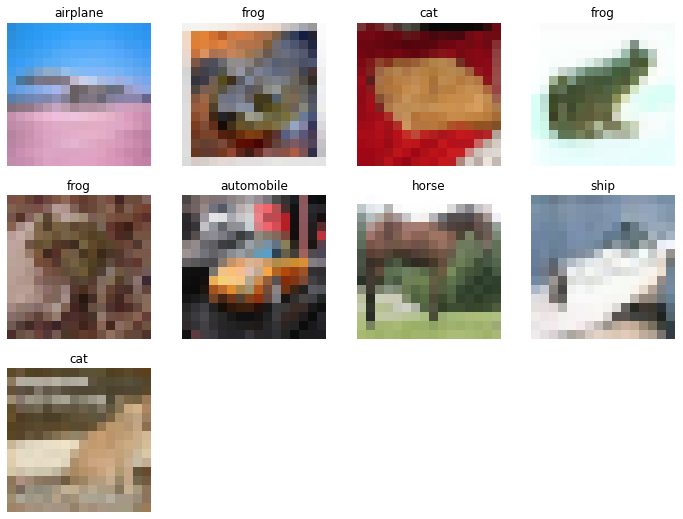

In [29]:
dls.valid.show_batch(nrows=3, ncols=4)



# Train the first model

Let's start with a simple model—a neural network using a pre-trained ResNet18. We'll see how well it does before making improvements.

In [31]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.550536,2.008386,0.306100,00:27


epoch,train_loss,valid_loss,accuracy,time
0,2.076427,1.773486,0.368100,00:28
1,1.868832,1.651968,0.408000,00:23
2,1.684803,1.538406,0.446600,00:27
3,1.542636,1.444739,0.478900,00:23
4,1.443781,1.382442,0.502100,00:23
5,1.365005,1.317129,0.532900,00:24
6,1.316527,1.264858,0.550900,00:29
7,1.251986,1.236673,0.559700,00:28
8,1.204498,1.201006,0.572200,00:28
9,1.171849,1.185623,0.580600,00:27


In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=50)

[('cat', 'dog', 205),
 ('truck', 'automobile', 191),
 ('automobile', 'truck', 179),
 ('dog', 'cat', 151),
 ('deer', 'horse', 129),
 ('bird', 'frog', 128),
 ('cat', 'frog', 125),
 ('deer', 'frog', 113),
 ('ship', 'airplane', 110),
 ('dog', 'horse', 106),
 ('ship', 'automobile', 104),
 ('airplane', 'ship', 100),
 ('bird', 'deer', 91),
 ('bird', 'dog', 78),
 ('ship', 'truck', 74),
 ('cat', 'bird', 72),
 ('deer', 'bird', 72),
 ('horse', 'deer', 70),
 ('dog', 'frog', 69),
 ('horse', 'dog', 69),
 ('deer', 'cat', 59),
 ('bird', 'cat', 57),
 ('airplane', 'bird', 56),
 ('airplane', 'truck', 56),
 ('bird', 'airplane', 56),
 ('cat', 'horse', 55),
 ('dog', 'deer', 54),
 ('cat', 'deer', 53),
 ('frog', 'deer', 53),
 ('dog', 'bird', 51),
 ('bird', 'horse', 50),
 ('frog', 'cat', 50)]

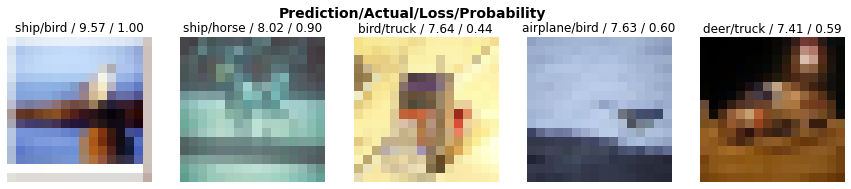

In [34]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
learn.export('baseline_export.pkl')

# Iterate and Improve the Model
The first attempt is never perfect. To improve, we'll tweak our model by adjusting parameters, changing architectures, and seeing what works best. Our final model reached an accuracy of **77.7%**. This relied on discriminative learning rates, presizing, and Leslie Smith's technique for finding the learning rate. 

## The Best Model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


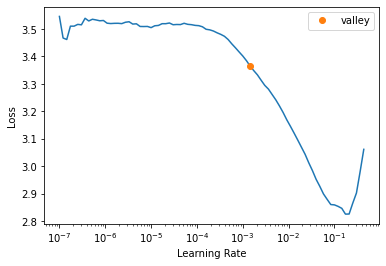

In [59]:
# Model D
n_epochs = 32
cifar = DataBlock(
    blocks = [ImageBlock, CategoryBlock],
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    batch_tfms=aug_transforms(size=24, min_scale=0.75)
)
dls = cifar.dataloaders(path/'train', 
                        bs = 512, 
                        seed = 42)
learn = vision_learner(dls, resnet18, metrics=accuracy)
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.458459,1.714187,0.432300,00:23
1,1.839833,1.476324,0.483800,00:25
2,1.624287,1.423428,0.499400,00:26


SuggestedLRs(valley=0.0008317637839354575)

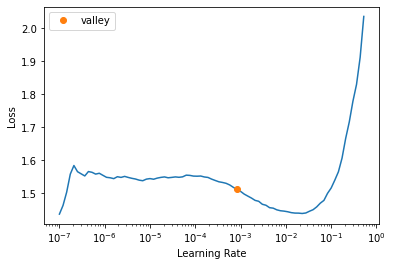

In [61]:
base_lr = 1.4e-3
learn.freeze()
learn.fit_one_cycle(3, base_lr)
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.492095,1.698559,0.433000,00:29
1,1.857048,1.463014,0.495400,00:30
2,1.633801,1.423831,0.501000,00:28


epoch,train_loss,valid_loss,accuracy,time
0,1.446787,1.295929,0.548800,00:29
1,1.269360,1.142912,0.602900,00:28
2,1.092596,1.073082,0.636900,00:28
3,0.965740,1.008197,0.670700,00:30
4,0.894361,1.037594,0.685900,00:30
5,0.850987,0.870906,0.704600,00:29
6,0.797181,0.848414,0.713000,00:29
7,0.755061,0.818326,0.731000,00:26
8,0.702218,0.763084,0.745400,00:30
9,0.668742,0.762206,0.747800,00:28


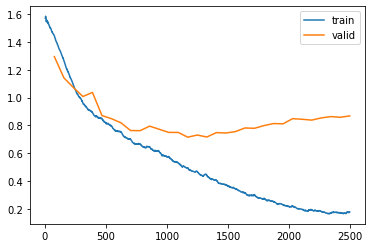

In [62]:
base_lr = 1.4e-3
disc_lr = slice(8e-5,8e-3)
freeze_epochs = 3
n_epochs = 32

learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.freeze()
learn.fit_one_cycle(freeze_epochs, base_lr)
learn.unfreeze()
learn.fit_one_cycle(n_epochs, disc_lr)
learn.recorder.plot_loss()

## Mixed Precision Training: Resnet101 

I decided to also test out mixed precision training to allow training of a much larger network, Resnet101, without taking too much time. The accuracy of the model actually did not improve with the deeper network. Seems like it should have, but there's much more to do before this model is SOTA. ImageNet pretraining may not be as good as simply training from scratch, and best efforts I ran across so far did not use pretrained Imagenet models, but instead started from scratch.

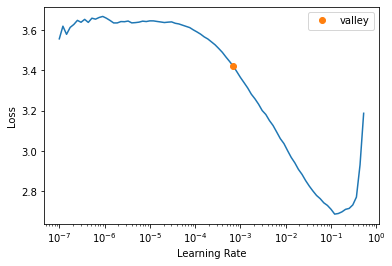

In [25]:
from fastai.callback.fp16 import *

cifar = DataBlock(
    blocks = [ImageBlock, CategoryBlock],
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    batch_tfms=aug_transforms(size=24, min_scale=0.75)
)
dls = cifar.dataloaders(path/'train', 
                        bs = 512, 
                        seed = 42)
learn = vision_learner(dls, resnet101, metrics=accuracy).to_fp16()
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.637301,1.372016,0.511300,00:36


SuggestedLRs(valley=0.00015848931798245758)

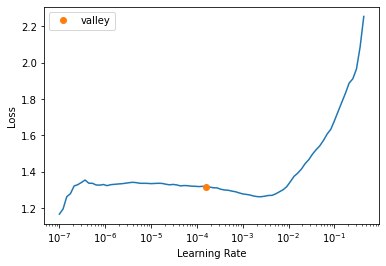

In [26]:
base_lr = 6e-3
learn.freeze()
learn.fit_one_cycle(1, base_lr)
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.641111,1.315193,0.536400,00:32


epoch,train_loss,valid_loss,accuracy,time
0,1.329345,1.266843,0.555600,00:40
1,1.246262,1.180738,0.581500,00:41
2,1.160876,1.114313,0.608000,00:41
3,1.059085,1.024999,0.646800,00:40
4,0.967155,0.956626,0.678800,00:41
5,0.883919,0.877438,0.696900,00:41
6,0.804704,0.896085,0.718200,00:40
7,0.770523,1.013896,0.705100,00:41
8,0.723203,0.837037,0.723600,00:44
9,0.664702,0.789105,0.733400,00:44


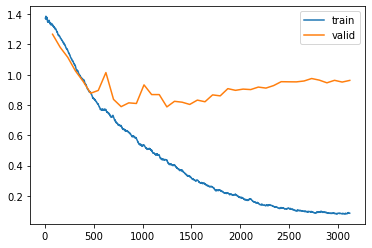

In [27]:
base_lr = 6e-3
disc_lr = slice(1e-5,1e-3)
freeze_epochs = 1
n_epochs = 40

learn = vision_learner(dls, resnet101, metrics=accuracy).to_fp16()
learn.freeze()
learn.fit_one_cycle(freeze_epochs, base_lr)
learn.unfreeze()
learn.fit_one_cycle(n_epochs, disc_lr)
learn.recorder.plot_loss()